# EE16A Homework 8

## Question 2: Deconstructing Trolls

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import wave as wv
import scipy
from scipy import io
import scipy.io.wavfile
from scipy.io.wavfile import read
from IPython.display import Audio
import warnings
warnings.filterwarnings('ignore')
sound_file_1 = 'm1.wav'
sound_file_2 = 'm2.wav'
rate1,corrupt1 = scipy.io.wavfile.read('m1.wav')
rate2,corrupt2 = scipy.io.wavfile.read('m2.wav')
corrupt1 = corrupt1.astype(np.float)
corrupt2 = corrupt2.astype(np.float)

Just like last time, let's listen to the inputs. 

In [27]:
Audio(url='m1.wav', autoplay=False)

In [28]:
Audio(url='m2.wav', autoplay=False)

In the cell below, complete the function to find the vectors $\vec{a}$ and $\vec{b}$. Make sure that $\vec{a}$ is the original speech and not the troll. 

In [31]:
def remove_troll(m1, m2):
    ## YOUR CODE HERE
    a = m1 - (np.dot(m1, m2)/ np.dot(m2, m2)) * m2
    b = m2
    return a, b

In [32]:
remove_troll(corrupt1, corrupt2)

(array([  2.59899156,   4.70696241,   3.34705959, ...,  91.47055935,
         86.64535883,  69.97438671]),
 array([ -211.,  -229.,  -169., ..., -1301., -1219.,  -996.]))

Run the cell below to test your function.

In [33]:
a, b = remove_troll(corrupt1, corrupt2)
Audio(data=a, rate=rate1)

Let's now compare our output here to the output from Homework 1. Read through the block of code below and comment on it's output

In [34]:
## First, let's compute the original vectors representing the speakers using the technique in homework 1.
a_u = np.sqrt(2)/(1+np.sqrt(3))
a_v = np.sqrt(6)/(1+np.sqrt(3))
b_u = np.sqrt(2)/(1+np.sqrt(3))
b_v = -1*np.sqrt(2)/(1+np.sqrt(3))
s1 = a_u*corrupt1 + a_v*corrupt2
s2 = b_u*corrupt1 + b_v*corrupt2

## Here, we will compute various dot products to see which vectors are orthogonal.
## Note that we normalize the vectors before we compare, this is because we want 
## to get rid of any scaling.
print("Dot product of the two original speaker outputs: ", np.dot(s1/np.linalg.norm(s1), s2/np.linalg.norm(s2)))
print("Dot product of calculated a and b: ", np.dot(a/np.linalg.norm(a), b/np.linalg.norm(b)))

Dot product of the two original speaker outputs:  -0.00379040459598
Dot product of calculated a and b:  2.77555756156e-17


## Question 3: Sparse Imaging

This example generates a sparse signal and tries to recover it using the orthogonal matching pursuit algorithm

In [11]:
# imports
import matplotlib.pyplot as plt
import numpy as np
from scipy import misc
from IPython import display
from simulator import *
%matplotlib inline

In [12]:
measurements, A = simulate()

# THE SETTINGS FOR THE IMAGE - PLEASE DO NOT CHANGE
height = 91
width = 120
sparsity = 476
numPixels = len(A[0])

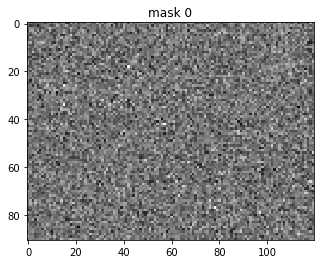

In [13]:
# CHOOSE DIFFERENT MASKS TO PLOT
chosenMaskToDisplay = 0

M0 = A[chosenMaskToDisplay].reshape((height,width))
plt.title('mask %d'%chosenMaskToDisplay)
plt.imshow(M0, cmap=plt.cm.gray, interpolation='nearest');

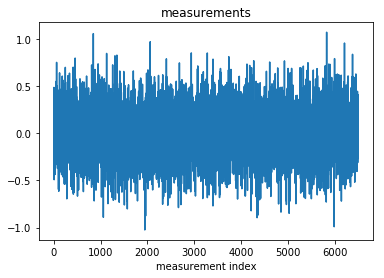

In [14]:
# measurements
plt.title('measurements')
plt.plot(measurements)
plt.xlabel('measurement index')
plt.show()

In [15]:
# OMP algorithm
# THERE ARE MISSING LINES THAT YOU NEED TO FILL
def OMP(imDims, sparsity, measurements, A):
    r = measurements.copy()
    indices = []
    
    # Threshold to check error. If error is below this value, stop.
    THRESHOLD = 0.1
    
    # For iterating to recover all signal
    i = 0
    
    while i < sparsity and np.linalg.norm(r) > THRESHOLD: 
        # Calculate the correlations
        print('%d - '%i,end="",flush=True)
        corrs = A.T.dot(r)

        # Choose highest-correlated pixel location and add to collection
        # COMPLETE THE LINE BELOW
        best_index = np.argmax(np.abs(corrs))
        indices.append(best_index)

        # Build the matrix made up of selected indices so far
        # COMPLETE THE LINE BELOW
        Atrunc = A[:,indices]

        # Find orthogonal projection of measurements to subspace
        # spanned by recovered codewords
        b = measurements
        # COMPLETE THE LINE BELOW
        xhat = np.linalg.lstsq(Atrunc, b)[0]  

        # Find component orthogonal to subspace to use for next measurement
        # COMPLETE THE LINE BELOW
        r = b - Atrunc.dot(xhat)

        # This is for viewing the recovery process
        if i % 10 == 0 or i == sparsity-1 or np.linalg.norm(r) <= THRESHOLD:
            recovered_signal = np.zeros(numPixels)
            for j, x in zip(indices, xhat):
                recovered_signal[j] = x
            Ihat = recovered_signal.reshape(imDims)
            plt.title('estimated image')
            plt.imshow(Ihat, cmap=plt.cm.gray, interpolation='nearest') 
            display.clear_output(wait=True)
            display.display(plt.gcf())
        
        i = i + 1
        
    display.clear_output(wait=True)

    # Fill in the recovered signal
    recovered_signal = np.zeros(numPixels)
    for i, x in zip(indices, xhat):
        recovered_signal[i] = x
    
    return recovered_signal

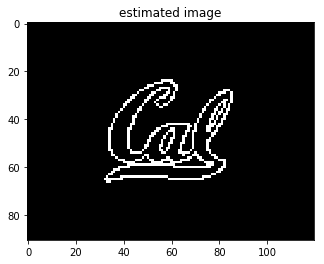

In [25]:
rec = OMP((height,width), sparsity, measurements, A)

### PRACTICE: Part (c)

In [ ]:
# the setting

# file name for the sparse image
fname = 'figures/smiley.png'
# number of measurements to be taken from the sparse image
numMeasurements = 6500
# the sparsity of the image
sparsity = 400

# read the image in black and white
I = misc.imread(fname, flatten=1)
# normalize the image to be between 0 and 1
I = I/np.max(I)

# shape of the image
imageShape = I.shape
# number of pixels in the image
numPixels = I.size

plt.title('input image')
plt.imshow(I, cmap=plt.cm.gray, interpolation='nearest');

In [ ]:
# generate your image masks and the underlying measurement matrix
Mask, A = randMasks(numMeasurements,numPixels)
# vectorize your image
full_signal = I.reshape((numPixels,1))
# get the measurements
measurements = np.dot(Mask,full_signal)
# remove the mean from your measurements
measurements = measurements - np.mean(measurements)

In [ ]:
# measurements
plt.title('measurements')
plt.plot(measurements)
plt.xlabel('measurement index')
plt.show()

In [ ]:
rec = OMP(imageShape, sparsity, measurements, A)

## Question 4: Speeding Up OMP

This example generates a sparse signal and tries to recover it using the orthogonal matching pursuit algorithm

In [16]:
# imports
import matplotlib.pyplot as plt
import numpy as np
from scipy import misc
from IPython import display
from simulator import *
%matplotlib inline

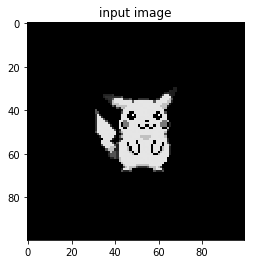

In [17]:
# the setting

# file name for the sparse image
fname = 'figures/pika.png'
# number of measurements to be taken from the sparse image
numMeasurements = 9000
# the sparsity of the image
sparsity = 800

# read the image in black and white
I = misc.imread(fname, flatten=1)
# normalize the image to be between 0 and 1
I = I/np.max(I)

# shape of the image
imageShape = I.shape
# number of pixels in the image
numPixels = I.size

plt.title('input image')
plt.imshow(I, cmap=plt.cm.gray, interpolation='nearest');

In [18]:
# generate your image masks and the underlying measurement matrix
Mask, A = randMasks(numMeasurements,numPixels)
# vectorize your image
full_signal = I.reshape((numPixels,1))
# get the measurements
measurements = np.dot(Mask,full_signal)
# remove the mean from your measurements
measurements = measurements - np.mean(measurements)

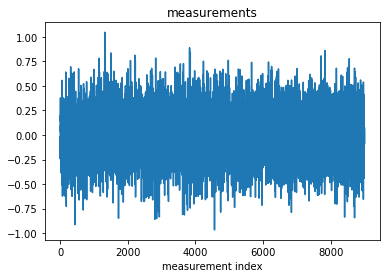

In [19]:
# measurements
plt.title('measurements')
plt.plot(measurements)
plt.xlabel('measurement index')
plt.show()

In [23]:
# Write a function that returns a matrix U whose columns form
# an orthonormal basis for the columns of the matrix A.
def gramschmidt(A):
    the_A = np.transpose(A)
    n = np,linalg.norm(the_A[0])
    U = the_A / n
    
    for i in range(1, len(the_A)):
        k = the_A[i]
        for j in range(len(U)):
            k -= np.dot(k, np.transpose(U[j]) * U[j])
        m = np.linalg.norm(k)
        if m > 0:
            U = np.vstack((U, k / m))
    U = np.transpose(U)
    return U

# A better option is to write a function that takes in a matrix U0
# with orthonormal columns and a single new vector v and adds another
# orthonormal column to U0 creating a new matrix U whose columns are orthonormal
# and span the column space of {U0, v}.
# Note: Using this function will make your code faster.
def gramschmidt_addone(U0,v):
    if len(U0) == 0:
        U = v / np.linalg.norm(v)
    else:
        v2 = v - np.dot(U0, np.dot(np.transpose(U0), v))
        v2 = v2 / np.linalg.norm(v2)
        U = np.column_stack((U0, v2))
    return U

In [24]:
# THERE ARE MISSING LINES THAT YOU NEED TO FILL
def OMP(imDims, sparsity, measurements, A):
    r = measurements.copy()
    indices = []
    
    # Threshold to check error. If error is below this value, stop.
    THRESHOLD = 0.1
    
    # For iterating to recover all signal
    i = 0
    
    ########################################
    ### THIS LINE INITIALIZES THE MATRIX U
    U = np.zeros([np.size(A,0),0])
    ########################################
    
    while i < sparsity and np.linalg.norm(r) > THRESHOLD: 
        # calculate the correlations
        print('%d - '%i,end="",flush=True)
        corrs = A.T.dot(r)

        # Choose highest-correlated pixel location and add to collection
        # COMPLETE THE LINE BELOW
        best_index = np.argmax(np.abs(corrs))
        
        ###########################
        ### MODIFY THIS SECTION ###
        ## TO USE GRAM-SCHMIDT  ###
        ###########################
                
        indices.append(best_index)
        

        
        # Build the matrix made up of selected indices so far
        # COMPLETE THE LINE BELOW
        Atrunc = A[:,indices]
        
        #############################
        ## CHOOSE ONE OF THESE LINES
#         U = gramschmidt(Atrunc)
        ### OR
        v = A[:,best_index]
        U = gramschmidt_addone(U,v)
        #############################
        
        # Find orthogonal projection of measurements to subspace
        # spanned by recovered codewords
        b = measurements
        
        ###################################
        ## COMPLETE THE LINES BELOW AND
        ## REWRITE THESE LINES USING GRAMSCHMIDT TO SPEED UP LEAST SQUARES
        xhat = np.linalg.lstsq(Atrunc, b)[0]  
        r = b - Atrunc.dot(xhat)
        ####################################
        
        # Find component orthogonal to subspace to use for next measurement
        ## CHANGE THIS LINE        
        
        ###########################
        ### ------------------- ###
        ###########################

        
        # This is for viewing the recovery process
        if i % 100 == 0 or i == sparsity-1 or np.linalg.norm(r) <= THRESHOLD:
            
            # RECOVERING xhat for plotting
            xhat = np.dot(np.linalg.inv(np.dot(Atrunc.T,Atrunc)),np.dot(Atrunc.T,b-r))
            
            recovered_signal = np.zeros(numPixels)
            for j, x in zip(indices, xhat):
                recovered_signal[j] = x
            Ihat = recovered_signal.reshape(imDims)
            plt.title('estimated image')
            plt.imshow(Ihat, cmap=plt.cm.gray, interpolation='nearest') 
            display.clear_output(wait=True)
            display.display(plt.gcf())
        
        i = i + 1
        
    display.clear_output(wait=True)

    # Fill in the recovered signal
    recovered_signal = np.zeros(numPixels)
    for i, x in zip(indices, xhat):
        recovered_signal[i] = x
    
    return recovered_signal

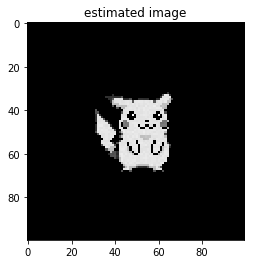

In [25]:
rec = OMP(imageShape, sparsity, measurements, A)